In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import jit
import time 

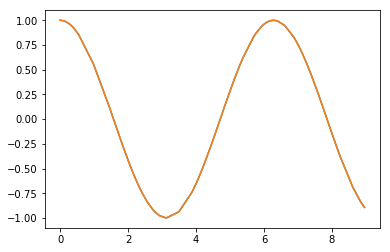

Numpy interp function:0.00031304359436035156
My interp function:9.918212890625e-05


'\nAlthough the interp function performs well when there are few points at which to interpolate, as the number of \npoints increases, the time drastically inceases compared to the numpy function. The issue could be np.digitize, \nhowever, it uses a binary search which is hard to speed up. This part of the code could be done using \narray broadcasting, but when testing it, it was ulitimately slower than digitize, although that may depend \non the number of grid points. \n\nThe broadcasting goes something along these lines and a brodcasting interp function is provided below,\nhowever, when tested, it is slower than the digitize.\n\nxt1 = xt.copy().reshape(len(grid),1)\nbins = np.argmin(abs(xt1-x), axis = 0)\n\nThere are also a number of border cases that could be improved. One such case is when the grid domain is greater \nthan the X domain. Another is when the grid is random. \n'

In [3]:
""" Problem 1 """

@jit
def interp(xt, x, y):
    dy = y[1:] - y[:-1]
    dx = x[1:] - x[:-1]
    b = dy/dx
    bins = np.digitize(xt, x) - 1
    return y[bins] + b[bins]*(xt-x[bins])

x = np.linspace(0,10,1000)
y = np.cos(x)
grid = np.sort(np.random.rand(100)*9)

interp1 = np.interp(grid,x,y)
interp2 = interp(grid,x,y)

plt.plot(grid, interp1)
plt.plot(grid, interp2)
plt.show()

#timeit isn't working so use time.time()
#%timeit np.interp(grid,x,y)
#%timeit interp(grid,x,y)

time1 = time.time()
np.interp(grid,x,y)
time2= time.time()
print("Numpy interp function:" + str(time2-time1))

time1 = time.time()
interp(grid,x,y)
time2= time.time()
print("My interp function:" + str(time2-time1))

"""
Although the interp function performs well when there are few points at which to interpolate, as the number of 
points increases, the time drastically inceases compared to the numpy function. The issue could be np.digitize, 
however, it uses a binary search which is hard to speed up. This part of the code could be done using 
array broadcasting, but when testing it, it was ulitimately slower than digitize, although that may depend 
on the number of grid points. 

The broadcasting goes something along these lines and a brodcasting interp function is provided below,
however, when tested, it is slower than the digitize.

xt1 = xt.copy().reshape(len(grid),1)
bins = np.argmin(abs(xt1-x), axis = 0)

There are also a number of border cases that could be improved. One such case is when the grid domain is greater 
than the X domain. Another is when the grid is random. 
"""

In [4]:
def broad_interp(xt, x, y):
    dy = y[1:] - y[:-1]
    dx = x[1:] - x[:-1]
    b = dy/dx
    xt1 = xt.copy().reshape(len(xt),1)
    bins = np.argmin(abs(xt1-x), axis = 1)
    return y[bins] + b[bins]*(xt-x[bins])

time1 = time.time()
broad_interp(grid,x,y)
time2= time.time()
print("Numpy interp function:" + str(time2-time1))

Numpy interp function:0.004924297332763672


In [5]:
def coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: np.interp(x, y, c)
    return Kg

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)
    
lg = LogLinearOG()

# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star, c_star = lg.v_star, lg.c_star
u, u_prime, f, f_prime = lg.u, lg.u_prime, lg.f, lg.f_prime

grid_max = 4         # Largest grid point, exogenous grid
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

k_grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

In [6]:
## Define the model

alpha = 0.65
beta = 0.95
mu = 0
s = 0.1
grid_min = 1e-6
grid_max = 4
grid_size = 200
shock_size = 250

gamma = 1.5   # Preference parameter
gamma_inv = 1 / gamma

def f(k):
    return k**alpha

def f_prime(k):
    return alpha * k**(alpha - 1)

def u(c):
    return (c**(1 - gamma) - 1) / (1 - gamma)

def u_prime(c):
    return c**(-gamma)

def u_prime_inv(c):
    return c**(-gamma_inv)

k_grid = np.linspace(grid_min, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))


In [10]:
"""Problem 2 """

def coleman_egm1(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: interp(x, y, c)
    return Kg

sim_length = 20
print("Timing policy function iteration with Numpy Interp")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)
    g = new_g
qe.util.toc()

print("Timing policy function iteration with my Interp")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = coleman_egm1(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)
    g = new_g
qe.util.toc()

Timing policy function iteration with Numpy Interp
TOC: Elapsed: 0.6118190288543701 seconds.
Timing policy function iteration with my Interp
TOC: Elapsed: 0.5762159824371338 seconds.


0.5762159824371338